In [ ]:
!pip install transformers
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 24.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, classification_report
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Ruta al archivo CSV en tu Google Drive
file_path = '/content/drive/MyDrive/TDG Maestría/df_embeddings2.csv'

# Cargar el archivo CSV en un DataFrame
df = pd.read_csv(file_path, delimiter=',')

In [ ]:
df

,embeddings,texto,PAGO ENCODED
0,"[-0.0344289168715477, -0.011757023632526398, 0...",maria jose toma mensaje\nsandra contesta dice ...,1
1,"[-0.02272099256515503, 0.011927139014005661, -...",cliente paga el \ncliente paga el,1
2,"[-0.014189556241035461, -0.011459204368293285,...",saldo total \nmotivo de mora se recuerda con...,0
3,"[-0.03110261633992195, -0.009308687411248684, ...",tt informa pagar la fra el dia de febrero por...,0
4,"[-0.011689751408994198, 0.00041755306301638484...",tt informa pagar la fra para el dia de febrer...,1
...,...,...,...
75282,"[-0.02338041178882122, 0.003643700620159507, 0...",se incluye seguro de vida por los meses de jun...,1
75283,"[-0.026033105328679085, -0.005082813091576099,...",se comunica cliente el cual informa que el mot...,1
75284,"[-0.021802477538585663, -0.009296522475779057,...",vozy,1
75285,"[-0.0167300496250391, -0.0037518583703786135, ...",se aplica descuento de ultima cuota ampliando ...,1


In [ ]:
z = df['embeddings'].tolist()
y = df["PAGO ENCODED"].tolist()

# Conteo de labels


In [ ]:
import matplotlib.pyplot as plt
conteo_categorias = df['PAGO ENCODED'].value_counts()

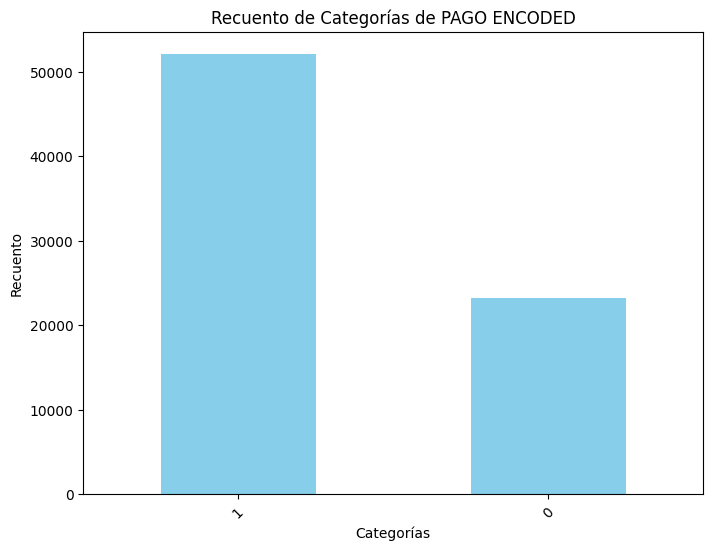

In [ ]:
# Crea un gráfico de barras
plt.figure(figsize=(8, 6))
conteo_categorias.plot(kind='bar', color='skyblue')
plt.xlabel('Categorías')
plt.ylabel('Recuento')
plt.title('Recuento de Categorías de PAGO ENCODED')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mayor claridad
plt.show()

# Split entre train y test


In [ ]:
embeddings = df['embeddings'].tolist()
labels = df['PAGO ENCODED'].tolist()

In [ ]:
train_embeddings, test_embeddings, train_labels, test_labels = train_test_split(embeddings, labels, test_size=0.2, random_state=42)

In [ ]:
train_embeddings = [list(map(float, emb[1:-1].split(', '))) for emb in train_embeddings]
test_embeddings = [list(map(float, emb[1:-1].split(', '))) for emb in test_embeddings]


# Modelo Random Forest sin Undersampling

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

clf = RandomForestClassifier(n_estimators=100)
clf.fit(train_embeddings, train_labels)
preds = clf.predict(test_embeddings)

In [ ]:
class_report = classification_report(test_labels, preds)
print("Reporte de Clasificación:\n", class_report)

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.30      0.03      0.06      4714
           1       0.69      0.96      0.80     10344

    accuracy                           0.67     15058
   macro avg       0.49      0.50      0.43     15058
weighted avg       0.56      0.67      0.57     15058



#Under Sampler

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

# Convierte la columna 'TEXTO PROCESADO' en una matriz bidimensional
X = np.array(df['embeddings']).reshape(-1, 1)

# Convierte la columna 'PAGO ENCODED' en una matriz unidimensional
y = np.array(df['PAGO ENCODED'])

# Aplica submuestreo aleatorio para la clase mayoritaria
rus = RandomUnderSampler(sampling_strategy='majority')
X_resampled, y_resampled = rus.fit_resample(X, y)

In [ ]:
df2 = pd.DataFrame({
    'TEXTO PROCESADO': X_resampled.reshape(-1),
    'PAGO ENCODED': y_resampled
})

In [ ]:
conteo_categorias = df2['PAGO ENCODED'].value_counts()

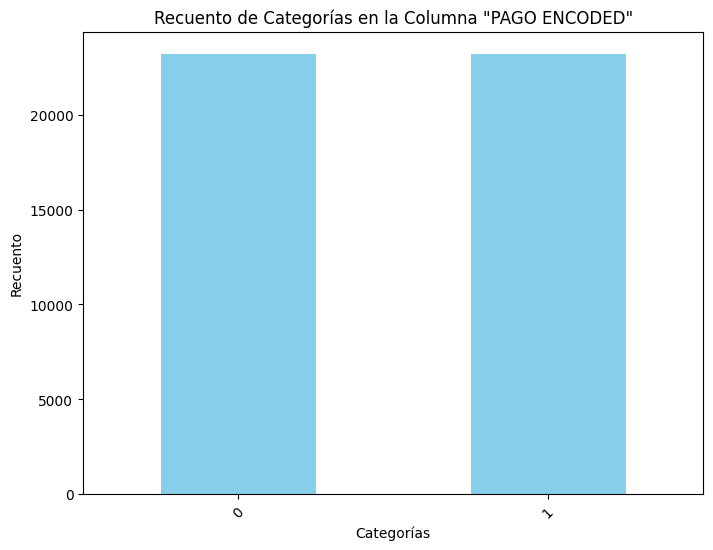

In [ ]:
# Crea un gráfico de barras
plt.figure(figsize=(8, 6))
conteo_categorias.plot(kind='bar', color='skyblue')
plt.xlabel('Categorías')
plt.ylabel('Recuento')
plt.title('Recuento de Categorías en la Columna "PAGO ENCODED"')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mayor claridad
plt.show()

In [ ]:
df2

,TEXTO PROCESADO,PAGO ENCODED
0,"[-0.014189556241035461, -0.011459204368293285,...",0
1,"[-0.03110261633992195, -0.009308687411248684, ...",0
2,"[-0.013025359250605106, 0.004342913161963224, ...",0
3,"[-0.033023007214069366, -0.003555815666913986,...",0
4,"[-0.024244681000709534, -0.0031119431369006634...",0
...,...,...
46421,"[-0.020581068471074104, -0.010283812880516052,...",1
46422,"[-0.009900201112031937, -0.01266742218285799, ...",1
46423,"[-0.02881176583468914, 0.009173311293125153, 0...",1
46424,"[-0.03495944291353226, -0.01221679151058197, 0...",1


# Entrenamiento Random Forest con UnderSampler

In [ ]:
embeddings2 = df2['TEXTO PROCESADO'].tolist()
labels2 = df2['PAGO ENCODED'].tolist()

In [ ]:
train_embeddings2, test_embeddings2, train_labels2, test_labels2 = train_test_split(embeddings2, labels2, test_size=0.2, random_state=42)


In [ ]:
train_embeddings2 = [list(map(float, emb[1:-1].split(', '))) for emb in train_embeddings2]
test_embeddings2 = [list(map(float, emb[1:-1].split(', '))) for emb in test_embeddings2]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

clf = RandomForestClassifier(n_estimators=100)
clf.fit(train_embeddings2, train_labels2)
preds = clf.predict(test_embeddings2)

In [ ]:
class_report = classification_report(test_labels2, preds)
print("Reporte de Clasificación:\n", class_report)

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.50      0.48      0.49      4618
           1       0.50      0.52      0.51      4668

    accuracy                           0.50      9286
   macro avg       0.50      0.50      0.50      9286
weighted avg       0.50      0.50      0.50      9286



#Preparacion Red Neuronal sin UnderSampler


In [ ]:
train_embeddings_tensor = torch.tensor(train_embeddings)
test_embeddings_tensor = torch.tensor(test_embeddings)
train_labels_tensor = torch.tensor(train_labels)
test_labels_tensor = torch.tensor(test_labels)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "dccuchile/bert-base-spanish-wwm-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier.bias', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_dataset = TensorDataset(train_embeddings_tensor,train_labels_tensor )
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = TensorDataset(test_embeddings_tensor,test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# Definir los hiperparámetros de entrenamiento
learning_rate = 2e-3
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_loader) * 3  # 3 epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


#Red Neuronal

In [ ]:
import torch
import torch.nn as nn

# Supongamos que 'train_embeddings_tensor' y 'test_embeddings_tensor' son tus embeddings preentrenados
# Asegúrate de que estos tensores tienen la forma adecuada, por ejemplo, (num_muestras, longitud_embedding)

# Definir la arquitectura de la red neuronal
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Tamaño de los embeddings (por ejemplo, 1536 en tu caso)
input_size = 1536
# Número de neuronas en la capa oculta
hidden_size = 500
# Número de clases de salida (en tu caso, 2 para spam y no spam)
output_size = 2

# Instanciar el modelo
model = NeuralNetwork(input_size, hidden_size, output_size)

# Asegurarse de que los embeddings estén en el dispositivo correcto (por ejemplo, GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_embeddings_tensor = train_embeddings_tensor.to(device)
test_embeddings_tensor = test_embeddings_tensor.to(device)
model = model.to(device)

# Pasar los embeddings a través del modelo
output = model(train_embeddings_tensor)

# Ahora puedes usar 'output' para calcular la pérdida y realizar la retropropagación


#Entrenamiento Red

In [ ]:
from tqdm import tqdm

# Definir las etiquetas de entrenamiento (por ejemplo, train_labels_tensor)
# Asegurarse de que las etiquetas estén en el dispositivo correcto
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_labels_tensor = train_labels_tensor.to(device)

# Definir la función de pérdida (por ejemplo, entropía cruzada)
criterion = nn.CrossEntropyLoss()

# Mover el modelo a la GPU si está disponible
model = model.to(device)

# Definir el optimizador (por ejemplo, Adam)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Número de épocas de entrenamiento
num_epochs = 5

# Bucle de entrenamiento con barra de progreso
for epoch in range(num_epochs):
    total_loss = 0
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:
        for batch in train_loader:
            embeddings, labels = batch
            embeddings, labels = embeddings.to(device), labels.to(device)

            # Pasar los embeddings a través del modelo
            outputs = model(embeddings)

            # Calcular la pérdida
            loss = criterion(outputs, labels)

            # Realizar la retropropagación y la actualización de los parámetros
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix(loss=total_loss / (pbar.n + 1))  # Actualizar la pérdida en la barra de progreso
            pbar.update()

    # Mostrar el progreso del entrenamiento
    print(f'Epoch {epoch + 1}: Average Loss: {total_loss / len(train_loader):.4f}')


Epoch 1/5: 100%|██████████| 3765/3765 [01:16<00:00, 49.39batch/s, loss=0.619]


Epoch 1: Average Loss: 0.6186


Epoch 2/5: 100%|██████████| 3765/3765 [01:28<00:00, 42.59batch/s, loss=0.617]


Epoch 2: Average Loss: 0.6173


Epoch 3/5: 100%|██████████| 3765/3765 [01:31<00:00, 41.23batch/s, loss=0.617]


Epoch 3: Average Loss: 0.6167


Epoch 4/5: 100%|██████████| 3765/3765 [01:31<00:00, 41.30batch/s, loss=0.616]


Epoch 4: Average Loss: 0.6165


Epoch 5/5: 100%|██████████| 3765/3765 [01:34<00:00, 40.00batch/s, loss=0.616]

Epoch 5: Average Loss: 0.6160


#Evaluacion

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Evaluar el modelo en datos de prueba
model.eval()  # Poner el modelo en modo de evaluación
with torch.no_grad():
    # Pasar los embeddings de prueba a través del modelo
    test_outputs = model(test_embeddings_tensor)
    # Obtener las predicciones (clases) del modelo
    _, predicted_labels = torch.max(test_outputs, 1)

# Convertir las etiquetas predichas a numpy array para usar con scikit-learn
predicted_labels = predicted_labels.cpu().numpy()
true_labels = test_labels_tensor.cpu().numpy()

# Calcular métricas de clasificación
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# Imprimir las métricas
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Mostrar el reporte de clasificación
class_names = ['Clase 0', 'Clase 1']  # Reemplaza con los nombres de tus clases
print(classification_report(true_labels, predicted_labels, target_names=class_names))


Accuracy: 0.6869
Precision: 0.6869
Recall: 1.0000
F1-Score: 0.8144
              precision    recall  f1-score   support

     Clase 0       0.00      0.00      0.00      4714
     Clase 1       0.69      1.00      0.81     10344

    accuracy                           0.69     15058
   macro avg       0.34      0.50      0.41     15058
weighted avg       0.47      0.69      0.56     15058



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
train_embeddings_tensor2 = torch.tensor(train_embeddings2)
test_embeddings_tensor2 = torch.tensor(test_embeddings2)
train_labels_tensor2 = torch.tensor(train_labels2)
test_labels_tensor2 = torch.tensor(test_labels2)

In [ ]:
train_dataset2 = TensorDataset(train_embeddings_tensor2,train_labels_tensor2)
train_loader2 = DataLoader(train_dataset2, batch_size=16, shuffle=True)

test_dataset2 = TensorDataset(test_embeddings_tensor2,test_labels_tensor2)
test_loader2 = DataLoader(test_dataset2, batch_size=16, shuffle=False)

In [ ]:
from tqdm import tqdm

# Definir las etiquetas de entrenamiento (por ejemplo, train_labels_tensor)
# Asegurarse de que las etiquetas estén en el dispositivo correcto
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_labels_tensor = train_labels_tensor2.to(device)

# Definir la función de pérdida (por ejemplo, entropía cruzada)
criterion = nn.CrossEntropyLoss()

# Mover el modelo a la GPU si está disponible
model = model.to(device)

# Definir el optimizador (por ejemplo, Adam)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Número de épocas de entrenamiento
num_epochs = 5

# Bucle de entrenamiento con barra de progreso
for epoch in range(num_epochs):
    total_loss = 0
    with tqdm(total=len(train_loader2), desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:
        for batch in train_loader2:
            embeddings, labels = batch
            embeddings, labels = embeddings.to(device), labels.to(device)

            # Pasar los embeddings a través del modelo
            outputs = model(embeddings)

            # Calcular la pérdida
            loss = criterion(outputs, labels)

            # Realizar la retropropagación y la actualización de los parámetros
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix(loss=total_loss / (pbar.n + 1))  # Actualizar la pérdida en la barra de progreso
            pbar.update()

    # Mostrar el progreso del entrenamiento
    print(f'Epoch {epoch + 1}: Average Loss: {total_loss / len(train_loader2):.4f}')

Epoch 1/5: 100%|██████████| 2322/2322 [00:47<00:00, 48.59batch/s, loss=0.694]


Epoch 1: Average Loss: 0.6944


Epoch 2/5: 100%|██████████| 2322/2322 [00:51<00:00, 44.83batch/s, loss=0.692]


Epoch 2: Average Loss: 0.6923


Epoch 3/5: 100%|██████████| 2322/2322 [00:56<00:00, 41.21batch/s, loss=0.692]


Epoch 3: Average Loss: 0.6916


Epoch 4/5: 100%|██████████| 2322/2322 [00:55<00:00, 42.02batch/s, loss=0.691]


Epoch 4: Average Loss: 0.6914


Epoch 5/5: 100%|██████████| 2322/2322 [00:54<00:00, 42.65batch/s, loss=0.691]


Epoch 5: Average Loss: 0.6909


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Evaluar el modelo en datos de prueba
model.eval()  # Poner el modelo en modo de evaluación
with torch.no_grad():
    # Pasar los embeddings de prueba a través del modelo
    test_outputs = model(test_embeddings_tensor2)
    # Obtener las predicciones (clases) del modelo
    _, predicted_labels = torch.max(test_outputs, 1)

# Convertir las etiquetas predichas a numpy array para usar con scikit-learn
predicted_labels = predicted_labels.cpu().numpy()
true_labels = test_labels_tensor2.cpu().numpy()

# Calcular métricas de clasificación
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# Imprimir las métricas
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Mostrar el reporte de clasificación
class_names = ['Clase 0', 'Clase 1']  # Reemplaza con los nombres de tus clases
print(classification_report(true_labels, predicted_labels, target_names=class_names))

Accuracy: 0.5162
Precision: 0.5146
Recall: 0.6594
F1-Score: 0.5781
              precision    recall  f1-score   support

     Clase 0       0.52      0.37      0.43      4618
     Clase 1       0.51      0.66      0.58      4668

    accuracy                           0.52      9286
   macro avg       0.52      0.52      0.51      9286
weighted avg       0.52      0.52      0.51      9286



#Mejora a la arquitectura de la red

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_prob=0.5):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)  # Batch normalization after the first hidden layer
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)  # Batch normalization after the second hidden layer
        self.dropout = nn.Dropout(dropout_prob)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
input_size = 1536
hidden_size1 = 1536
hidden_size2 = 1536
output_size = 2
model2 = NeuralNetwork(input_size, hidden_size1, hidden_size2, output_size)

# Entrenamiento con dataset balanceado

In [ ]:
from tqdm import tqdm

# Definir las etiquetas de entrenamiento (por ejemplo, train_labels_tensor)
# Asegurarse de que las etiquetas estén en el dispositivo correcto
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_labels_tensor = train_labels_tensor2.to(device)

# Definir la función de pérdida (por ejemplo, entropía cruzada)
criterion = nn.CrossEntropyLoss()

# Mover el modelo a la GPU si está disponible
model = model2.to(device)

# Definir el optimizador (por ejemplo, Adam)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Número de épocas de entrenamiento
num_epochs = 5

# Bucle de entrenamiento con barra de progreso
for epoch in range(num_epochs):
    total_loss = 0
    with tqdm(total=len(train_loader2), desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:
        for batch in train_loader2:
            embeddings, labels = batch
            embeddings, labels = embeddings.to(device), labels.to(device)

            # Pasar los embeddings a través del modelo
            outputs = model2(embeddings)

            # Calcular la pérdida
            loss = criterion(outputs, labels)

            # Realizar la retropropagación y la actualización de los parámetros
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix(loss=total_loss / (pbar.n + 1))  # Actualizar la pérdida en la barra de progreso
            pbar.update()

    # Mostrar el progreso del entrenamiento
    print(f'Epoch {epoch + 1}: Average Loss: {total_loss / len(train_loader2):.4f}')

Epoch 1/5: 100%|██████████| 2322/2322 [03:23<00:00, 11.39batch/s, loss=0.693]


Epoch 1: Average Loss: 0.6932


Epoch 2/5: 100%|██████████| 2322/2322 [03:58<00:00,  9.74batch/s, loss=0.69]


Epoch 2: Average Loss: 0.6904


Epoch 3/5: 100%|██████████| 2322/2322 [03:56<00:00,  9.83batch/s, loss=0.688]


Epoch 3: Average Loss: 0.6884


Epoch 4/5: 100%|██████████| 2322/2322 [03:59<00:00,  9.69batch/s, loss=0.686]


Epoch 4: Average Loss: 0.6861


Epoch 5/5: 100%|██████████| 2322/2322 [04:01<00:00,  9.62batch/s, loss=0.684]

Epoch 5: Average Loss: 0.6838


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Evaluar el modelo en datos de prueba
model2.eval()  # Poner el modelo en modo de evaluación
with torch.no_grad():
    # Pasar los embeddings de prueba a través del modelo
    test_outputs = model(test_embeddings_tensor2)
    # Obtener las predicciones (clases) del modelo
    _, predicted_labels = torch.max(test_outputs, 1)

# Convertir las etiquetas predichas a numpy array para usar con scikit-learn
predicted_labels = predicted_labels.cpu().numpy()
true_labels = test_labels_tensor2.cpu().numpy()

# Calcular métricas de clasificación
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# Imprimir las métricas
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Mostrar el reporte de clasificación
class_names = ['Clase 0', 'Clase 1']  # Reemplaza con los nombres de tus clases
print(classification_report(true_labels, predicted_labels, target_names=class_names))

Accuracy: 0.5226
Precision: 0.5233
Recall: 0.5660
F1-Score: 0.5438
              precision    recall  f1-score   support

     Clase 0       0.52      0.48      0.50      4618
     Clase 1       0.52      0.57      0.54      4668

    accuracy                           0.52      9286
   macro avg       0.52      0.52      0.52      9286
weighted avg       0.52      0.52      0.52      9286



# Entrenamiento dataset desbalanceado

In [ ]:
from tqdm import tqdm

# Definir las etiquetas de entrenamiento (por ejemplo, train_labels_tensor)
# Asegurarse de que las etiquetas estén en el dispositivo correcto
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_labels_tensor = train_labels_tensor2.to(device)

# Definir la función de pérdida (por ejemplo, entropía cruzada)
criterion = nn.CrossEntropyLoss()

# Mover el modelo a la GPU si está disponible
model = model2.to(device)

# Definir el optimizador (por ejemplo, Adam)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Número de épocas de entrenamiento
num_epochs = 5

# Bucle de entrenamiento con barra de progreso
for epoch in range(num_epochs):
    total_loss = 0
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:
        for batch in train_loader:
            embeddings, labels = batch
            embeddings, labels = embeddings.to(device), labels.to(device)

            # Pasar los embeddings a través del modelo
            outputs = model2(embeddings)

            # Calcular la pérdida
            loss = criterion(outputs, labels)

            # Realizar la retropropagación y la actualización de los parámetros
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix(loss=total_loss / (pbar.n + 1))  # Actualizar la pérdida en la barra de progreso
            pbar.update()

    # Mostrar el progreso del entrenamiento
    print(f'Epoch {epoch + 1}: Average Loss: {total_loss / len(train_loader):.4f}')

Epoch 1/5: 100%|██████████| 3765/3765 [06:07<00:00, 10.23batch/s, loss=0.619]


Epoch 1: Average Loss: 0.6193


Epoch 2/5: 100%|██████████| 3765/3765 [07:21<00:00,  8.53batch/s, loss=0.617]


Epoch 2: Average Loss: 0.6170


Epoch 3/5: 100%|██████████| 3765/3765 [07:36<00:00,  8.25batch/s, loss=0.617]


Epoch 3: Average Loss: 0.6166


Epoch 4/5: 100%|██████████| 3765/3765 [07:38<00:00,  8.21batch/s, loss=0.616]


Epoch 4: Average Loss: 0.6160


Epoch 5/5: 100%|██████████| 3765/3765 [07:44<00:00,  8.10batch/s, loss=0.615]

Epoch 5: Average Loss: 0.6152


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Evaluar el modelo en datos de prueba
model2.eval()  # Poner el modelo en modo de evaluación
with torch.no_grad():
    # Pasar los embeddings de prueba a través del modelo
    test_outputs = model(test_embeddings_tensor)
    # Obtener las predicciones (clases) del modelo
    _, predicted_labels = torch.max(test_outputs, 1)

# Convertir las etiquetas predichas a numpy array para usar con scikit-learn
predicted_labels = predicted_labels.cpu().numpy()
true_labels = test_labels_tensor.cpu().numpy()

# Calcular métricas de clasificación
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# Imprimir las métricas
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Mostrar el reporte de clasificación
class_names = ['Clase 0', 'Clase 1']  # Reemplaza con los nombres de tus clases
print(classification_report(true_labels, predicted_labels, target_names=class_names))

Accuracy: 0.6869
Precision: 0.6869
Recall: 1.0000
F1-Score: 0.8144
              precision    recall  f1-score   support

     Clase 0       0.00      0.00      0.00      4714
     Clase 1       0.69      1.00      0.81     10344

    accuracy                           0.69     15058
   macro avg       0.34      0.50      0.41     15058
weighted avg       0.47      0.69      0.56     15058



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
